In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sc
import scipy.stats as stats
from sklearn.metrics.pairwise import cosine_similarity as cos_sim
%matplotlib inline

In [2]:
data = pd.read_csv('data/Flight-Overbooking-Data.csv')

In [3]:
# Convert Date column to datetime. The rest of the data is clean
data["Date"] = pd.to_datetime(data["Date"])

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 5 columns):
Date      730 non-null datetime64[ns]
Demand    730 non-null int64
Booked    730 non-null int64
Shows     730 non-null int64
Rate      730 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 28.6 KB


In [5]:
lam = int(data.Demand.mean())

In [6]:
var_check = int(data.Demand.var())

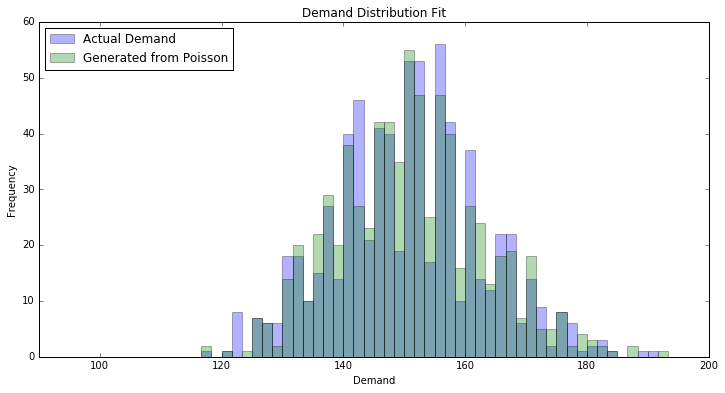

In [7]:
# Plot histogram of the demand data with generated sample Poisson data histogram to see how Poisson distribution fits
plt.figure(figsize=(12,6))
bins = np.linspace(80, 200, 73)
actual_demand = data["Demand"].values
poisson = np.random.poisson(lam = lam, size = 730)
plt.hist(actual_demand, bins, alpha = 0.3, label="Actual Demand")
plt.hist(poisson, bins, alpha = 0.3, label = "Generated from Poisson")
plt.xlim(90,200)
plt.xlabel("Demand")
plt.ylabel("Frequency")
plt.legend(loc='upper left')
plt.title("Demand Distribution Fit")
# plt.savefig("plots/distribution_fit_plot.png")
plt.show()

In [8]:
# Checking Poisson dist fit to actual demand data
cos_sim(actual_demand, poisson)

/Users/asalmitrofanov/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Users/asalmitrofanov/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


array([[ 0.99289731]])

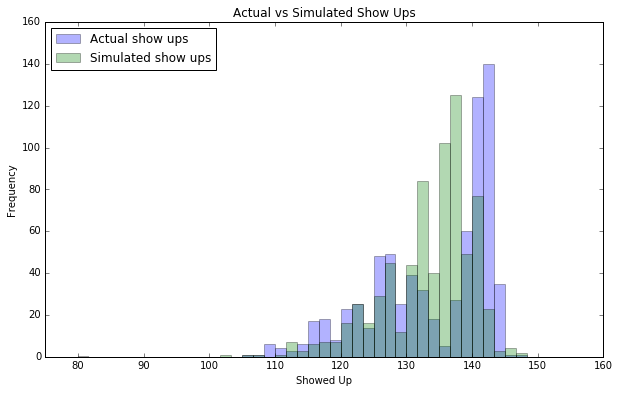

In [9]:
actual_show_ups = data.Shows.values
actual_p = data.Rate.values.mean()
actual_booked = data.Booked.values

# Setting overbooking limit
overbooking_lim = 15

# Limiting number of tickets booked to overbooking limit. 
# Using minimum of actual demand and number of seats + overbooking limit for n to simulate show ups with binomial dist
binomial_show_ups = np.array([np.random.binomial(n = min(x,(134+overbooking_lim)), p = actual_p) for x in actual_booked])

plt.figure(figsize=(10, 6))
plt.hist(actual_show_ups, bins, label = "Actual show ups", alpha = 0.3)
plt.hist(binomial_show_ups, bins, label = "Simulated show ups", alpha = 0.3)
plt.xlim(75, 160)
plt.ylim(0, 160)
plt.title("Actual vs Simulated Show Ups")
plt.xlabel("Showed Up")
plt.ylabel("Frequency")
plt.legend(loc="upper left")
plt.savefig("plots/actual_vs_simulated_show_ups.png")
plt.show()

In [10]:
# Checking binomial dist fit to actual show ups
cos_sim(actual_show_ups, binomial_show_ups)

/Users/asalmitrofanov/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Users/asalmitrofanov/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


array([[ 0.99921915]])

In [11]:
def demand_sim(lam, trials):
    """
    INPUT: lam = average historic demand, INT 
           trials = number of trials to run simulation, INT
           
    OUTPUT: sim_demand = simulated demand, NDARRAY, length = trials
    """
    sim_demand = np.random.poisson(lam=lam, size = trials)
    return sim_demand

In [27]:
demand_sim_test = demand_sim(150, 1000)
demand_sim_test[:5]

array([141, 140, 147, 135, 119])

In [14]:
def booking_capacity(seats, obl):
    """
    INPUT: seats = number of seats in the plane, INT
           obl = overbooking limit, INT
           
    OUTPUT: bc = booking capacity, INT
    """
    bc = seats + obl
    return bc

In [16]:
booking_cap = booking_capacity(134, 15)
booking_cap

149

In [36]:
def booked_tickets_sim(demand, booking_cap):
    """
    INPUT: demand = demand, INT
           booking_capacity  = max number of tickets for sale, INT
    OUTPUT: booked = number of booked tickets, INT
    """
    booked = min(demand, booking_cap)
    return booked

In [37]:
booked_test = booked_tickets_sim(demand_sim_test[0], booking_cap)
booked_test

141

In [38]:
def ready_to_board_sim(booked, p):
    """
    INPUT: booked = number of tickets booked, NDARRAY
           p = probability of show-up, FLOAT
           
    OUTPUT: showed_up = simulated number of passengers ready to board, INT
    """
    showed_up = np.random.binomial(n=booked, p=p)
    return showed_up

In [39]:
showed_up_test = ready_to_board_sim(booked_test, 0.92)
showed_up_test

132

In [40]:
def no_shows_sim(booked, ready_to_board):
    """
    INPUT: booked = number of tickets booked, INT
           ready_to_board = number of passengers ready to board, INT
    OUTPUT: no_shows = number of people missing the flight, INT 
    """
    no_shows = booked - ready_to_board
    return no_shows

In [43]:
no_shows_test = no_shows_sim(booked_test, showed_up_test)
no_shows_test

9

In [44]:
def bumped_sim(seats, ready_to_board):
    """
    INPUT: seats = number of seats in the plane, INT
           ready_to_board = number of passengers ready to board, INT
    OUTPUT: num_bumped = number of passengers bumped to later flight, INT
    """
    num_bumped = max(0, (ready_to_board-seats))
    return num_bumped

In [45]:
bumped_test = bumped_sim(134, showed_up_test)
bumped_test

0

In [34]:
def revenue_from_tickets_sim(ticket_price, number_tix_booked):
    """
    INPUT: ticket_price = fixed price per ticket, FLOAT
           number_tix_booked = number of tickets actually sold, FLOAT
    OUTPUT: revenue = revenue from ticket sales, FLOAT
    """
    revenue = ticket_price * number_tix_booked
    return revenue

In [ ]:
def profit_sim(obl, seats, ticket_price, trials = 500, lam, p):
    """
    Simulate flight profit distribution based on overbooking limit, number of seats and ticket price.
    INPUT: obl = overbooking limit, INT
           seats = number of seats in the plane, INT
           ticket_price = price per ticket sold, FLOAT
           rebook_fee = fee to rebook no-show ticke, FLOAT
           trials = number of trials to run simulation, INT
           lam = average historic demand to simulate demand from Poisson distribution, INT
           p = historic show-up rate
    
    OUTPUT: demand = simulated demand, NDARRAY
            booking_capacity = maximum allowed number of tickets to be sold for same flight, INT  
            booked = number of tickets sold, NDARRAY
            ready_to_board = simulated number of passengers ready to board, NDARRAY
            no_shows = number of no-shows, NDARRAY
            bumped = number of passengers bumped to later flight, NDARRAY
            tix_revenue
    """
    sim_demand = demand_simulation(lam, trials)
    booking_cap = booking_capacity(seats, obl)
    booked = nd.array([booked_tickets(x, booking_cap) for x in sim_demand])
    ready_to_board = nd.array([ready_to_board_sim(x, p) for x in booked])
    no_shows = nd.array([no_shows(x, y) for x in booked for y in ready_to_board])
    bumped = nd.array([bumped_sim(booking_cap, x) for x ready to board])
    tix_revenue
    return demand, booking_capacity, booked, ready_to_board, no_shows, bumped, tix_revenue, no_show_revenue, overbooking_cost